In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customers/extract - fees - data analyst - .csv
/kaggle/input/bank-customers/extract - cash request - data analyst.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
fees = pd.read_csv('/kaggle/input/bank-customers/extract - fees - data analyst - .csv')
cash_request = pd.read_csv('/kaggle/input/bank-customers/extract - cash request - data analyst.csv')

In [4]:
merged_df = fees.merge(
    cash_request, left_on="cash_request_id", right_on="id", suffixes=("_fees", "_cash")
)

In [5]:
# Filter dataset to only work on the paid credits to find anomalies
merged_df = merged_df[merged_df['status_cash'] == 'active']

In [6]:
date_cols = ["reimbursement_date", "money_back_date"]
for col in date_cols:
    merged_df[col] = pd.to_datetime(merged_df[col], errors='coerce')

# Create a new feature: repayment delay in days
merged_df["repayment_delay"] = (merged_df["money_back_date"] - merged_df["reimbursement_date"]).dt.days

# Set the repayment_delay to -1 when we couldn't calculate it. 
merged_df["repayment_delay"].fillna(-1, inplace=True)


In [7]:
# Define segmentation based on repayment behavior
def categorize_repayment(row):
    '''
         "Defaulter" refers to a customer who has not repaid the money at all
         "Late Payer" refers to a customer who returned the money after the expected reimbursement date.
    '''
    if pd.isna(row["money_back_date"]):
        return "Defaulter"
    elif row["money_back_date"] <= row["reimbursement_date"]:
        return "On-time Payer"
    else:
        return "Late Payer"

In [8]:
merged_df["Repayment_Status"] = merged_df.apply(categorize_repayment, axis=1)

In [9]:
# Display the segmented data
print(merged_df[["cash_request_id", "reimbursement_date", "money_back_date", "Repayment_Status" ,"repayment_delay"]].head())

      cash_request_id        reimbursement_date  \
42            25769.0 2020-12-05 11:00:00+00:00   
286           21997.0 2021-03-05 00:00:00+00:00   
538           21997.0 2021-03-05 00:00:00+00:00   
932            7638.0 2020-08-10 22:00:00+00:00   
1004          12304.0 2020-12-05 11:00:00+00:00   

                      money_back_date Repayment_Status  repayment_delay  
42   2020-12-07 11:57:32.229614+00:00       Late Payer              2.0  
286                               NaT        Defaulter             -1.0  
538                               NaT        Defaulter             -1.0  
932                               NaT        Defaulter             -1.0  
1004 2020-12-07 11:55:30.526200+00:00       Late Payer              2.0  


In [10]:
from sklearn.ensemble import IsolationForest
# Select features for anomaly detection
features = ["total_amount", "amount", "repayment_delay"]
merged_df.dropna(subset=features, inplace=True)
X = merged_df[features]

# Train Isolation Forest for anomaly detection
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
merged_df["Anomaly_Score"] = iso_forest.fit_predict(X)

# Label anomalies (-1 means an anomaly)
merged_df["Anomaly"] = merged_df["Anomaly_Score"].apply(lambda x: "Anomalous" if x == -1 else "Normal")

# Display the segmented data with anomaly detection
merged_df.head()

,id_fees,cash_request_id,type,status_fees,category,total_amount,reason,created_at_fees,updated_at_fees,paid_at,...,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,repayment_delay,Repayment_Status,Anomaly_Score,Anomaly
42,19333,25769.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 25769,2020-10-28 18:26:09.582877+00,2020-12-09 15:28:23.861333+00,2020-12-07 16:54:02.237895+00,...,2020-12-07 11:57:32.229614+00:00,instant,2020-10-28 18:26:01.884943+00,pending,2020-12-18 13:12:48.625182+00,2020-12-18 13:12:48.625199+00,2.0,Late Payer,-1,Anomalous
286,20205,21997.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 21997,2020-10-30 16:52:04.10348+00,2020-10-30 16:52:04.103513+00,NaN,...,NaT,instant,2020-10-18 17:47:54.909042+00,NaN,NaN,NaN,-1.0,Defaulter,1,Normal
538,20213,21997.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 21997,2020-10-30 16:52:14.92605+00,2020-10-30 16:52:14.926085+00,NaN,...,NaT,instant,2020-10-18 17:47:54.909042+00,NaN,NaN,NaN,-1.0,Defaulter,1,Normal
932,7825,7638.0,incident,rejected,month_delay_on_payment,5.0,month delay on payment - 9/2020,2020-09-16 00:51:48.127889+00,2020-10-13 14:25:02.750693+00,NaN,...,NaT,regular,NaN,pending,2020-08-16 22:13:44.949938+00,2020-08-18 10:06:22.665326+00,-1.0,Defaulter,1,Normal
1004,20574,12304.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 12304,2020-10-31 07:56:09.772732+00,2020-10-31 07:56:09.772755+00,NaN,...,2020-12-07 11:55:30.526200+00:00,instant,2020-08-20 07:48:49.453136+00,pending,2020-12-18 13:14:30.462404+00,2020-12-18 13:14:30.462421+00,2.0,Late Payer,-1,Anomalous


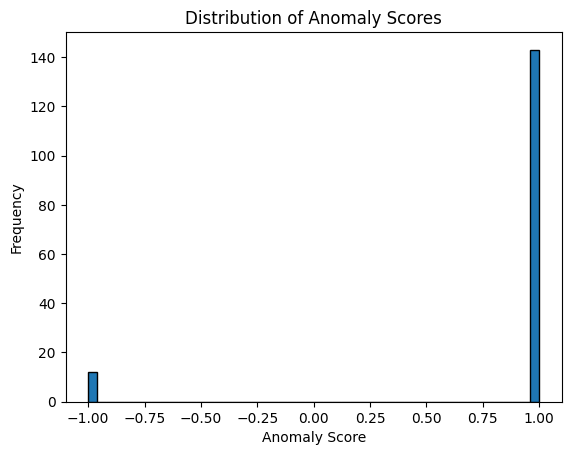

In [11]:
import matplotlib.pyplot as plt


plt.hist(merged_df["Anomaly_Score"], bins=50, edgecolor='black')
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores")
plt.show()

In [12]:
print(merged_df["Anomaly"].value_counts(normalize=True) * 100)


Anomaly
Normal       92.258065
Anomalous     7.741935
Name: proportion, dtype: float64


In [13]:
anomalies = merged_df[merged_df["Anomaly"] == "Anomalous"]
print(anomalies[["cash_request_id", "total_amount", "repayment_delay", "Repayment_Status"]].head(50))


       cash_request_id  total_amount  repayment_delay Repayment_Status
42             25769.0           5.0              2.0       Late Payer
1004           12304.0           5.0              2.0       Late Payer
6017           12304.0           5.0              2.0       Late Payer
6907           25006.0           5.0             -1.0        Defaulter
10784          12304.0           5.0              2.0       Late Payer
17438          12304.0           5.0              2.0       Late Payer
17471          12304.0           5.0              2.0       Late Payer
17573          12304.0           5.0              2.0       Late Payer
17574          12304.0           5.0              2.0       Late Payer
20691          25700.0           5.0             -1.0        Defaulter
20822          25182.0           5.0             -1.0        Defaulter
20937          23617.0           5.0             -1.0        Defaulter


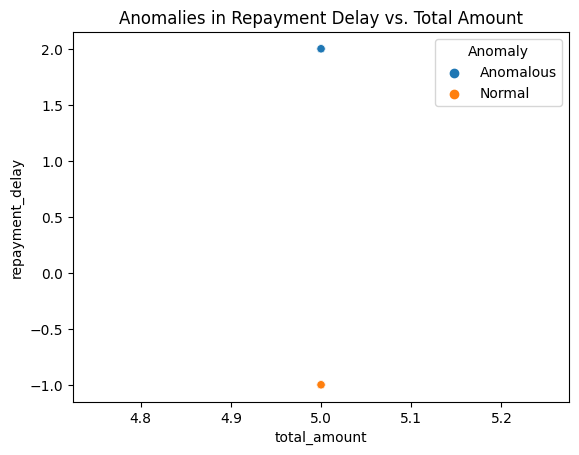

In [14]:
import seaborn as sns

sns.scatterplot(data=merged_df, x="total_amount", y="repayment_delay", hue="Anomaly")
plt.title("Anomalies in Repayment Delay vs. Total Amount")
plt.show()

In [15]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
merged_df["LOF_Anomaly_Score"] = lof.fit_predict(X)

print(merged_df["LOF_Anomaly_Score"].value_counts())  # Compare with Isolation Forest results

LOF_Anomaly_Score
 1    145
-1     10
Name: count, dtype: int64


In [16]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)  # Adjust contamination
merged_df["Anomaly_Score"] = iso_forest.fit_predict(X)

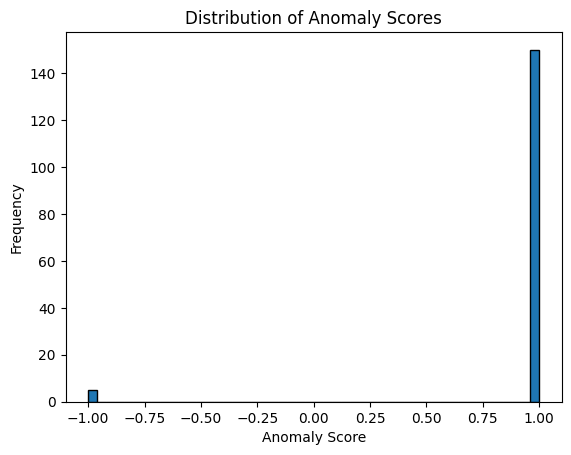

In [17]:
import matplotlib.pyplot as plt

plt.hist(merged_df["Anomaly_Score"], bins=50, edgecolor='black')
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores")
plt.show()

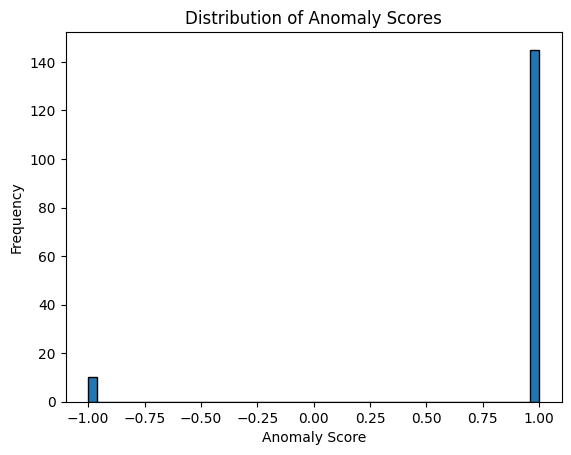

In [18]:
plt.hist(merged_df["LOF_Anomaly_Score"], bins=50, edgecolor='black')
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores")
plt.show()

In [19]:
print(merged_df[["Anomaly_Score", "LOF_Anomaly_Score"]].value_counts())

Anomaly_Score  LOF_Anomaly_Score
 1              1                   145
-1             -1                     5
 1             -1                     5
Name: count, dtype: int64


In [20]:
# Combine results from both algorithms
merged_df["Combined_Anomaly"] = (
    (merged_df["Anomaly_Score"] == -1) | (merged_df["LOF_Anomaly_Score"] == -1)
)

# Count combined anomalies
print(merged_df["Combined_Anomaly"].value_counts())

Combined_Anomaly
False    145
True      10
Name: count, dtype: int64


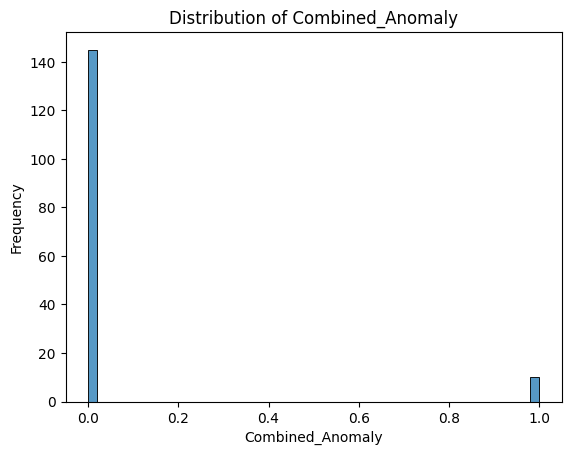

In [21]:
sns.histplot(merged_df["Combined_Anomaly"], bins=50, edgecolor='black')
plt.xlabel("Combined_Anomaly")
plt.ylabel("Frequency")
plt.title("Distribution of Combined_Anomaly")
plt.show()

In [22]:
print(merged_df["Combined_Anomaly"].value_counts(normalize=True) * 100)

Combined_Anomaly
False    93.548387
True      6.451613
Name: proportion, dtype: float64


In [23]:
anomalies = merged_df[merged_df["Combined_Anomaly"] == True]
print(anomalies[['user_id' ,'cash_request_id', 'total_amount', 'repayment_delay', 'Repayment_Status']].head(50))

       user_id  cash_request_id  total_amount  repayment_delay  \
42     37011.0          25769.0           5.0              2.0   
6907   26818.0          25006.0           5.0             -1.0   
16131  31489.0           9720.0           5.0             -1.0   
16152  31489.0           9720.0           5.0             -1.0   
19060  31489.0           9720.0           5.0             -1.0   
20266  31489.0           9720.0           5.0             -1.0   
20276  31489.0           9720.0           5.0             -1.0   
20691   2150.0          25700.0           5.0             -1.0   
20822  90160.0          25182.0           5.0             -1.0   
20937  45799.0          23617.0           5.0             -1.0   

      Repayment_Status  
42          Late Payer  
6907         Defaulter  
16131        Defaulter  
16152        Defaulter  
19060        Defaulter  
20266        Defaulter  
20276        Defaulter  
20691        Defaulter  
20822        Defaulter  
20937        Defaulter 

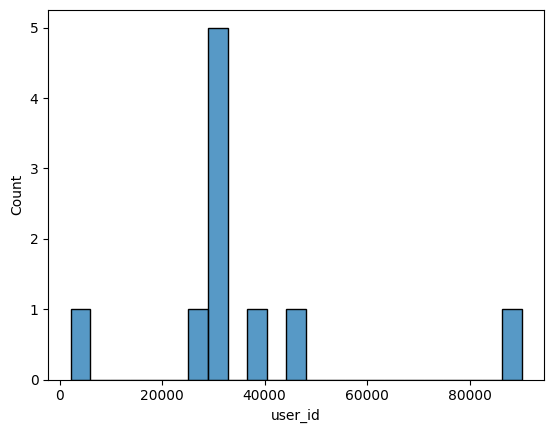

In [24]:
sns.histplot(anomalies , x='user_id')
plt.show()

<Axes: xlabel='Repayment_Status', ylabel='Count'>

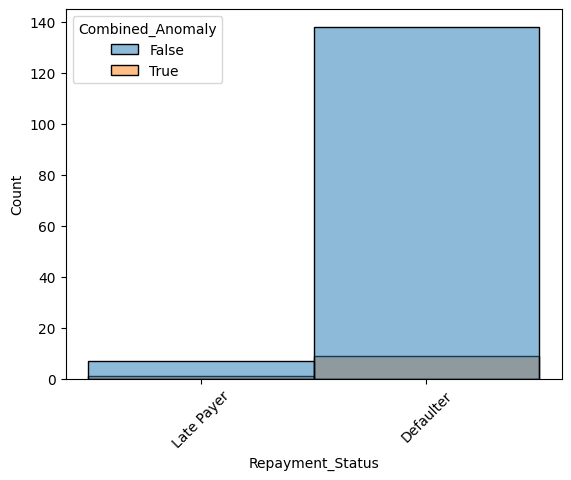

In [25]:
plt.xticks(rotation=45)
sns.histplot(data=merged_df , x='Repayment_Status' , hue='Combined_Anomaly')

       user_id  cash_request_id  total_amount  Combined_Anomaly
42     37011.0          25769.0           5.0              True
6907   26818.0          25006.0           5.0              True
16131  31489.0           9720.0           5.0              True
16152  31489.0           9720.0           5.0              True
19060  31489.0           9720.0           5.0              True
20266  31489.0           9720.0           5.0              True
20276  31489.0           9720.0           5.0              True
20691   2150.0          25700.0           5.0              True
20822  90160.0          25182.0           5.0              True
20937  45799.0          23617.0           5.0              True


<Axes: xlabel='total_amount', ylabel='Count'>

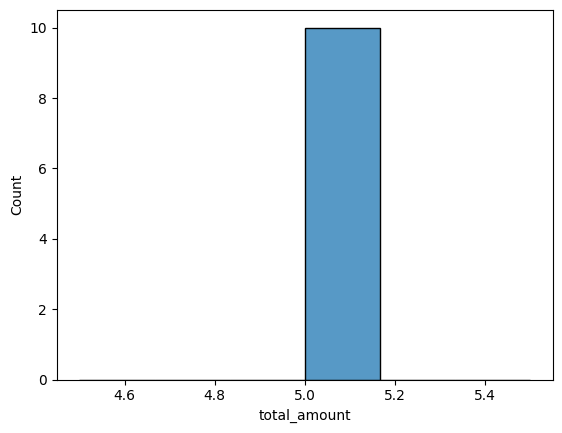

In [26]:
anomal_data = merged_df[merged_df['Combined_Anomaly']== True]
print(anomal_data[['user_id','cash_request_id','total_amount', 'Combined_Anomaly']])
sns.histplot(data=anomal_data, x='total_amount', bins=6)

Remeber to handel the paid_at column- now it has time convert it to month 

<Axes: xlabel='paid_at', ylabel='Count'>

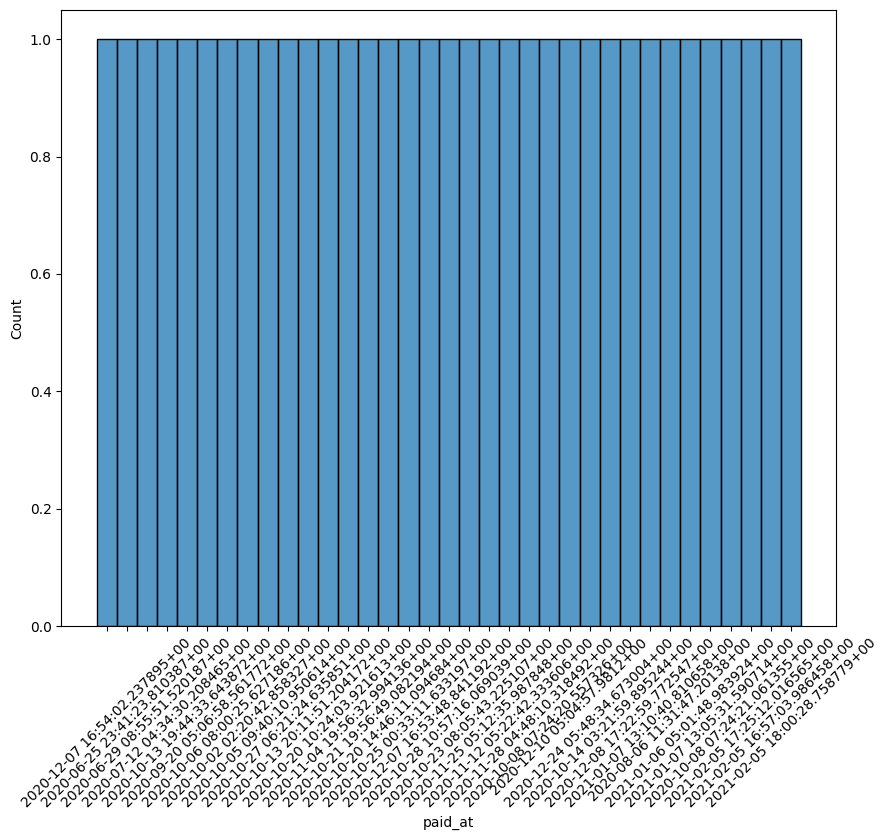

In [27]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
sns.histplot(data=merged_df , x='paid_at')


In [28]:
# distribution of Anomalies over other features
features = merged_df.describe().columns

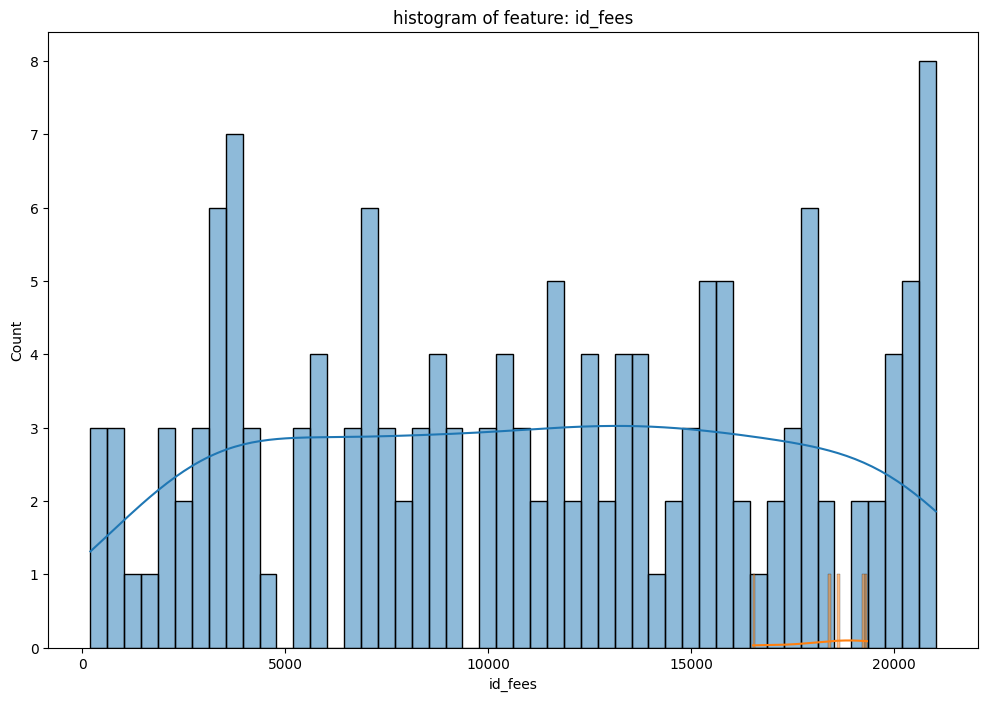

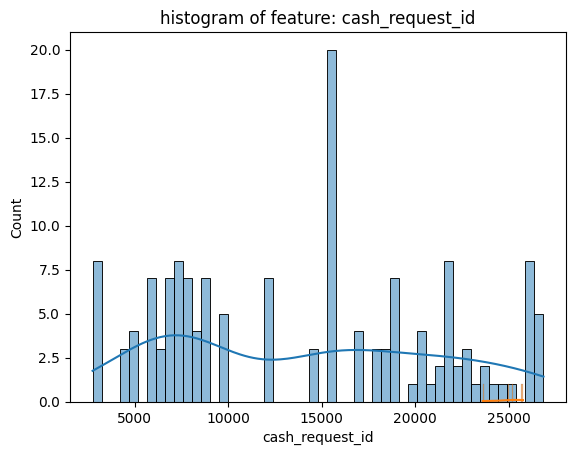

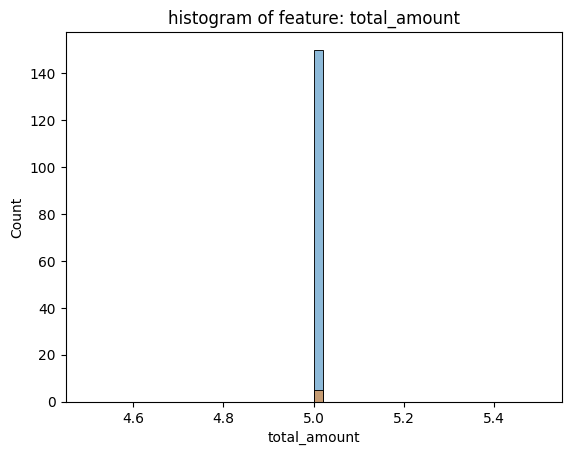

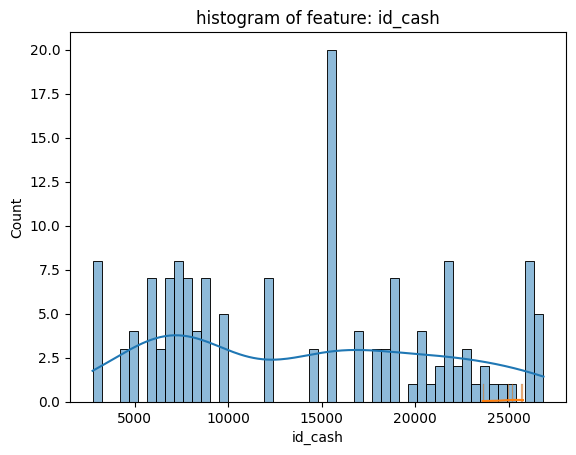

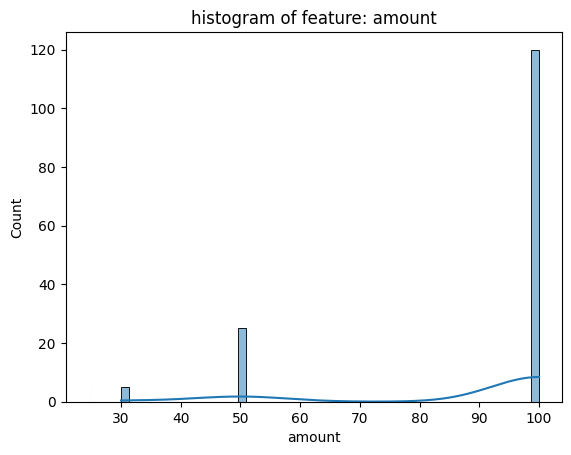

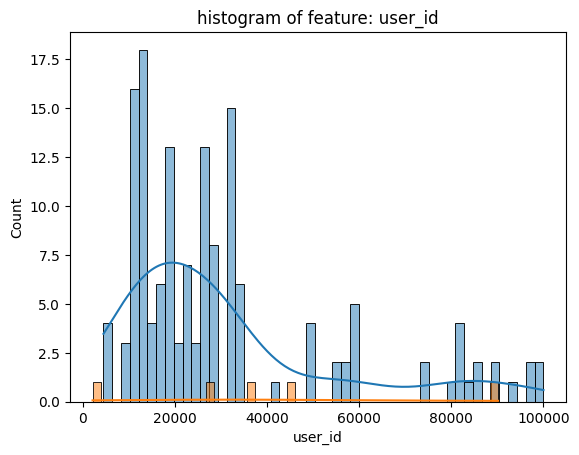

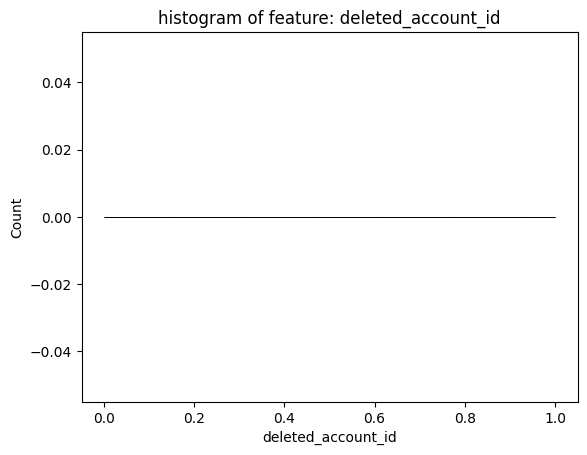

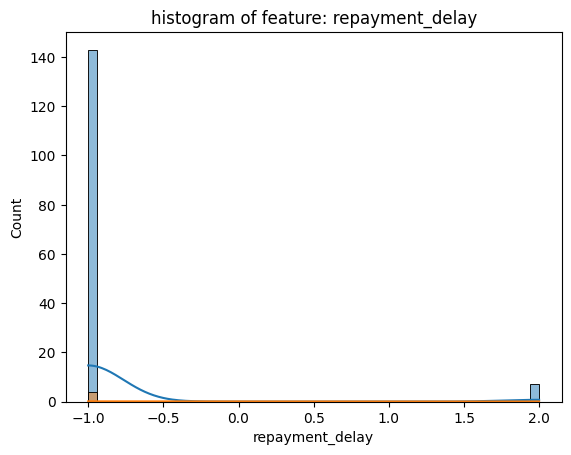

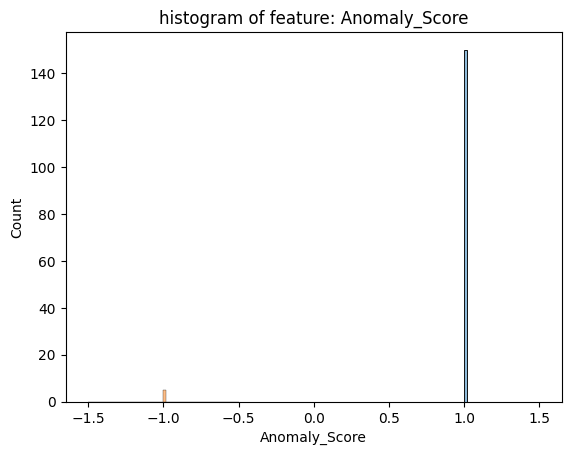

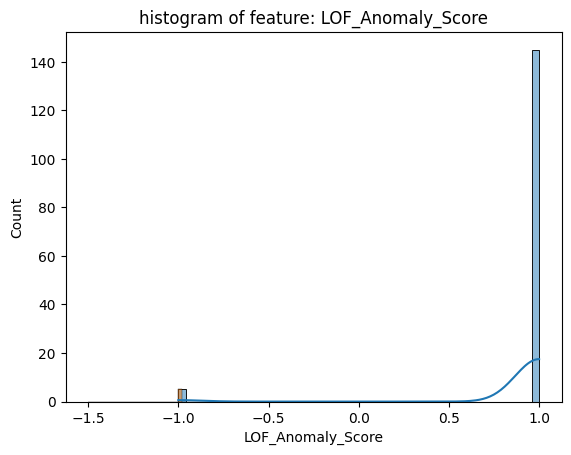

In [29]:
plt.figure(figsize=(12,8))

for feature in features:
    sns.histplot(merged_df[feature][merged_df.Anomaly_Score == 1], bins=50, kde=True, label="Normal")
    sns.histplot(merged_df[feature][merged_df.Anomaly_Score == -1], bins=50, kde=True, label="Anomalous")
    plt.title('histogram of feature: ' + str(feature))
    plt.show()

Total amount has value and there is no Null value it this column, but it still dosen't show the relation 

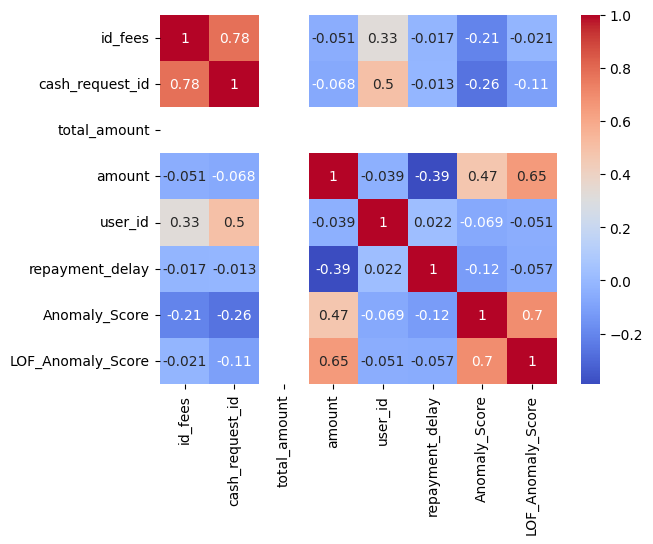

In [30]:
corr_df= merged_df.drop(columns=['id_cash', 'deleted_account_id'])
corr_matrix = corr_df[corr_df.describe().columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [31]:
merged_df['Repayment_Status'].unique()

array(['Late Payer', 'Defaulter'], dtype=object)

In [32]:
# Encode the Repayment_Status  and scale total amount
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder , StandardScaler

label_encoder = LabelEncoder() 
merged_df['Repayment_Status']= label_encoder.fit_transform(merged_df['Repayment_Status']) 
StandardScaler().fit_transform(merged_df['total_amount'].values.reshape(-1,1))

# Drop rows where 'Class' is NaN
merged_df = merged_df.dropna(subset=['Anomaly_Score'])

features_columns=['total_amount', 'repayment_delay', 'Repayment_Status']
target = 'Combined_Anomaly'
from sklearn.model_selection import train_test_split
 
# Define features (X) and target (y)
X = merged_df[features_columns]
y = merged_df[target]
 
# Split the data into training and testing sets
X_interp, X_extrap, y_interap, y_extrap = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = False)
X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interap, test_size=0.2, random_state=42, shuffle = True)

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

 
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train)
 
# Make predictions
y_pred = model.predict(X_test)
y_pred_extrap = model.predict(X_extrap)
 
# Print classification report
print("Classification Report Test:")
print(classification_report(y_test, y_pred))

print("Classification Report Extrap:")
print(classification_report(y_extrap, y_pred_extrap))
# Print accuracy score
print("Accuracy Score Test: ", accuracy_score(y_test, y_pred))
print("Accuracy Score Extarp: ", accuracy_score(y_extrap, y_pred_extrap))

Classification Report Test:
              precision    recall  f1-score   support

       False       0.88      1.00      0.94        22
        True       0.00      0.00      0.00         3

    accuracy                           0.88        25
   macro avg       0.44      0.50      0.47        25
weighted avg       0.77      0.88      0.82        25

Classification Report Extrap:
              precision    recall  f1-score   support

       False       0.84      1.00      0.91        26
        True       0.00      0.00      0.00         5

    accuracy                           0.84        31
   macro avg       0.42      0.50      0.46        31
weighted avg       0.70      0.84      0.77        31

Accuracy Score Test:  0.88
Accuracy Score Extarp:  0.8387096774193549


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Select features and target variable
features = ["total_amount", "amount", "repayment_delay"]  # Adjust based on dataset
X = merged_df[features].values  # Convert DataFrame to NumPy array
y = merged_df["Repayment_Status"].apply(lambda x: 1 if x == "Defaulter" else 0).values  # Convert labels

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape for CNN input (CNN expects 3D input: samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into training and testing data
X_interp, X_extrap, y_interp, y_extrap = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = False)
X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=0.2, random_state=42, shuffle = True)
print(f'X_interp.shape={X_interp.shape}, y_interp.shape={y_interp.shape}')
print(f'X_extrap.shape={X_extrap.shape}, y_extrap.shape={y_extrap.shape}')

X_interp.shape=(124, 3, 1), y_interp.shape=(124,)
X_extrap.shape=(31, 3, 1), y_extrap.shape=(31,)


In [35]:
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X.shape[1], 1)),
    Dropout(0.3),
    Conv1D(filters=32, kernel_size=1, activation='relu'),
    Conv1D(filters=32, kernel_size=1, activation='relu'),
    Dropout(0.3),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))
cnn_model.fit(X_extrap, y_extrap, epochs=50, batch_size=16, validation_data=(X_interp, y_interp) )

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.1450 - loss: 0.7288 - val_accuracy: 0.8800 - val_loss: 0.6696
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9783 - loss: 0.6538 - val_accuracy: 1.0000 - val_loss: 0.5898
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.5859 - val_accuracy: 1.0000 - val_loss: 0.4922
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.4920 - val_accuracy: 1.0000 - val_loss: 0.3593
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.3549 - val_accuracy: 1.0000 - val_loss: 0.2143
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.2137 - val_accuracy: 1.0000 - val_loss: 0.0974
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0993 - val_accuracy: 1.0000 - val_loss: 0.0339
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0359 - val_accuracy: 1.0000 - val_loss: 0.0111
Epoch 9

In [36]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [37]:
smote= SMOTE(random_state=42)
X , y= smote.fit_resample(merged_df[features], merged_df['Combined_Anomaly'])

scaler = StandardScaler()
X = scaler.fit_transform(X)


X_interp, X_extrap , y_interp, y_extrap = train_test_split(X, y, test_size=0.2 , shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp , test_size=0.2 , shuffle= True)
# Create a pipeline with SMOTE and Random Forest
pipeline = RandomForestClassifier(class_weight='balanced', random_state=42)

# Set up Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold CV

# Evaluate the model using cross-validation
cv_scores = cross_val_score(
    pipeline, X_train, y_train, cv=skf, scoring='roc_auc'  # Use ROC-AUC as the evaluation metric
)

# Print cross-validation results
print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Mean ROC-AUC: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

# Train the final model on the entire dataset (optional)
pipeline.fit(X_train, y_train)


Cross-Validation ROC-AUC Scores: [1. 1. 1. 1. 1.]
Mean ROC-AUC: 1.0000 (±0.0000)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [38]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_extrap= model.predict(X_extrap)
accuracy_extrap= accuracy_score(y_extrap,y_pred_extrap)
print(f'Extrapolation Accuracy: {accuracy_extrap:.4f}')

Test Accuracy: 0.5532
Extrapolation Accuracy: 0.0000
